In [3]:
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import pylab
import gc

In [2]:
def linear_regression(X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    b = np.linalg.inv(X.T@X)@X.T@y
    return b

def rmse(slopes, X_test, y_test):
    X_test = pd.get_dummies(X_test, drop_first = True)._get_numeric_data().values
    intercept_col = np.ones(X_test.shape[0]).reshape(X_test.shape[0],1)
    X_test = np.hstack((intercept_col, X_test))
    
    y_val_pred = X_test @ b
    y_val = y_test.values
    return np.sqrt(((y_val - y_val_pred) ** 2).mean())
    
def train_test_split(frac, X, response = 'Volume Sold (Gallons)'):
    X_train = X.sample(frac = frac)
    X_test = X.drop(X_train.index, axis = 0)
    
    y_train = X_train[response]
    X_train = X_train.drop(['County','Area Name',response], axis = 1)
    
    y_test = X_test[response]
    X_test = X_test.drop(['County','Area Name',response], axis = 1)
    
    return X_train,X_test, y_train, y_test

def r2(b, X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    
    ss_tot = ((y - y.mean()) ** 2).sum()
    
    y_val_pred = X @ b
    ss_res = ((y - y_val_pred) ** 2).sum()
    return 1 - (ss_res/ss_tot)

def adj_r2(b, X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    
    ss_tot = ((y - y.mean()) ** 2).sum()
    
    y_val_pred = X @ b
    ss_res = ((y - y_val_pred) ** 2).sum()
    
    r2 = 1 - (ss_res/ss_tot)
    return 1 - (((1 - r2) * (X.shape[0] - 1)) / (X.shape[0] - X.shape[1] - 1))

def qqplot(b, X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    
    y_val_pred = X @ b

    stats.probplot(y - y_val_pred, dist="norm", plot=pylab)
    pylab.show()

def aic(b, X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    y_val_pred = X @ b
    
    ss_tot = ((y - y.mean()) ** 2).sum()
    ss_res = ((y - y_val_pred) ** 2).sum()
    sigmasq = ss_tot / X.shape[0]
    p = X.shape[1]
    
    return (ss_res + 2 *(p * sigmasq)) / ss_tot

def bic(b, X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    y_val_pred = X @ b
    
    ss_tot = ((y - y.mean()) ** 2).sum()
    ss_res = ((y - y_val_pred) ** 2).sum()
    sigmasq = ss_tot / X.shape[0]
    p = X.shape[1]
    n = X.shape[0]
    
    return (ss_res + (np.log(n) * p * sigmasq)) / ss_tot

In [4]:
# LOAD IN MAIN DATASET
df = pd.read_csv("data/iowaliquor.csv")
# df_sample = pd.read_csv("data/iowa-sample.csv")

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# LOAD IN CENSUS DATASET
df_raw_county = pd.read_csv("data/co-est2019-alldata.csv", encoding = "ISO-8859-1")
df_raw_county["id"] = df_raw_county.index

In [6]:
df_county_year = pd.wide_to_long(df_raw_county.drop(["SUMLEV","REGION","DIVISION","STATE","COUNTY","CENSUS2010POP","ESTIMATESBASE2010"],axis = 1),
                  ["POPESTIMATE","NPOCHG_","BIRTHS",
                  "DEATHS","NATURALINC","INTERNATIONALMIG",
                  "DOMESTICMIG","NETMIG","RESIDUAL",
                  "GQESTIMATESBASE","RBIRTH","RDEATH","RNATURALINC",
                  "RINTERNATIONALMIG","RDOMESTICMIG","RNETMIG","NPOPCHG_","GQESTIMATES"], i="id", j="year")

df_county_year = df_county_year[df_county_year["STNAME"] == "Iowa"]
df_county_year["CTYNAME"] = df_county_year["CTYNAME"].str.replace(" County", "").str.lower()
df_county_year = df_county_year.drop("NPOCHG_", axis = 1).dropna(axis = 1)
df_county_year = df_county_year[["CTYNAME","POPESTIMATE"]]

In [ ]:
df_county_year.head()

In [7]:
# LOAD IN EMPLLOYMENT DATA
df_raw_employment = pd.read_csv("data/Iowa_Quarterly_Census_of_Employment_and_Wage_data__Statewide_and_County_.csv")
df_raw_employment.fillna(0)

,Year,Quarter,Area Type,Area Name,Industry,Description,Locations,Month 1,Month 2,Month 3,Average Emp,Wages,Average Wage
0,2011,1,Statewide,Statewide,11.0,"Agriculture, Forestry, Fishing & Hunt",1921.0,14343.0,14504.0,14895.0,14581.0,1.204824e+08,8263.0
1,2011,1,Statewide,Statewide,21.0,"Mining, Quarrying, & Oil & Gas Extrac",186.0,1638.0,1811.0,1818.0,1756.0,1.679560e+07,9567.0
2,2011,1,Statewide,Statewide,22.0,Utilities,449.0,8330.0,8288.0,8328.0,8315.0,1.593543e+08,19164.0
3,2011,1,Statewide,Statewide,23.0,Construction,8994.0,52324.0,51154.0,53629.0,52369.0,5.506093e+08,10514.0
4,2011,1,Statewide,Statewide,31.0,Manufacturing,3985.0,201803.0,202120.0,203641.0,202521.0,2.454029e+09,12117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230382,2015,2,County,Benton,515.0,Broadcasting (except Internet),0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0
230383,2015,2,County,Benton,517.0,Telecommunications,6.0,38.0,38.0,37.0,38.0,4.717600e+05,12525.0
230384,2015,2,County,Benton,518.0,"Data Processing, Hosting, Related",0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0
230385,2015,2,County,Benton,519.0,Other Information Services,1.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0


In [8]:
df_employement = pd.pivot_table(df_raw_employment,
               index = ["Year", "Quarter", "Area Name"],
               values = ["Average Emp", "Wages"],
               aggfunc = np.sum
              ).reset_index()

df_employement["Area Name"] = df_employement["Area Name"].str.lower()

In [9]:
df_employement["Year"] = df_employement["Year"].astype('str')
df_employement["Quarter"] = df_employement["Quarter"].astype('str')

In [ ]:
# df_employement.head()

In [10]:
df["County"] = df["County"].str.lower()

In [11]:
df["Year"] = pd.DatetimeIndex(df['Date']).year
df["Quarter"] = pd.DatetimeIndex(df['Date']).quarter

In [12]:
df["Year"] = df["Year"].astype('str')
df["Quarter"] = df["Quarter"].astype('str')
df["Pack"] = df["Pack"].astype('str')

In [13]:
GROUP_VARIABLES = ['County','Year','Quarter']
NUMERIC_VARIABLES = ['Bottle Volume (ml)','State Bottle Cost', 'State Bottle Retail',
                     'Bottles Sold','Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)']

df_agg =  pd.pivot_table(df, 
                        index = GROUP_VARIABLES,
                        values = NUMERIC_VARIABLES,
                        aggfunc = np.sum).reset_index().merge(df_employement, 'inner', left_on = ['Year','County', 'Quarter'], right_on = ['Year','Area Name', 'Quarter']).dropna()

In [14]:
df_county_year = df_county_year.reset_index()

In [15]:
df_agg["Year"] = df_agg["Year"].astype('int32')

In [16]:
df_agg = df_agg.merge(df_county_year, 'inner', left_on = ['Year','County'], right_on = ['year','CTYNAME']).dropna()

In [19]:
df_agg["Volume Sold (Gallons) per Capita"] = df_agg["Volume Sold (Gallons)"] / df_agg["POPESTIMATE"]

In [20]:
df_agg.head()

,County,Year,Quarter,Bottle Volume (ml),Bottles Sold,Sale (Dollars),State Bottle Cost,State Bottle Retail,Volume Sold (Gallons),Volume Sold (Liters),Area Name,Average Emp,Wages,id,year,CTYNAME,POPESTIMATE,Volume Sold (Gallons) per Capita
0,adair,2012,1,965450,7107,78426.57,7751.07,11660.15,1830.92,6932.89,adair,3941.0,25331409.0,805,2012,adair,7468,0.245169
1,adair,2012,2,1235100,9492,110003.28,10505.50,15816.48,2356.82,8925.63,adair,4377.0,28929023.0,805,2012,adair,7468,0.315589
2,adair,2012,3,1135625,8489,101681.95,9685.16,14563.81,2150.68,8144.73,adair,4317.0,29765410.0,805,2012,adair,7468,0.287986
3,adair,2012,4,1166300,9806,123579.68,10012.10,15093.50,2454.28,9293.77,adair,4261.0,30926473.0,805,2012,adair,7468,0.328640
4,adair,2013,1,855000,7129,82411.70,7072.67,10629.71,1786.17,6763.87,adair,4070.0,27122098.0,805,2013,adair,7387,0.241799


In [ ]:
#---------------------------------
# SALE (DOLLARS) AS RESPONSE VARIABLE
#---------------------------------

In [21]:
X_train,X_test, y_train, y_test = train_test_split(.5, df_agg,'Volume Sold (Gallons) per Capita')

In [22]:
VARS = ["Year","Quarter","Average Emp", "Wages"]
b = linear_regression(X_train[VARS], y_train)
r2(b, X_train[VARS], y_train)

(0.28554980926782736, 0.1663806759333981)

In [26]:
rmse(b, X_test[VARS], y_test)

0.1663806759333981

In [23]:
adj_r2(b, X_train[VARS], y_train)

0.2777960862676332

In [24]:
aic(b,X_test[VARS],y_test),bic(b,X_test[VARS],y_test)

(0.8712814436698016, 0.9193228524063025)

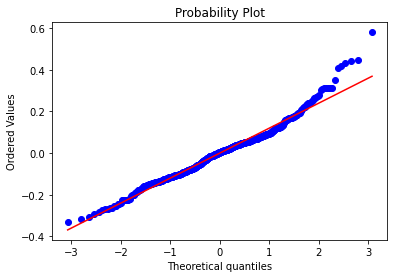

In [25]:
qqplot(b, X_train[VARS], y_train)